In [2]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from transformers import AdamW, get_scheduler

from jre_utils.datapath import (
    processed_pretraining_data_paths,
    pretraining_data_paths,
    pretrained_weights_paths,
)
from jre_utils.data import TimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.engine import (
    evaluate,
    train,
    evaluate_weightless,
    train_weightless,
    EarlyStopper,
)
from jre_utils.metrics import MSELossWeighted

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [3]:
dataset = "jena_climate"
df = pd.read_csv(pretraining_data_paths[dataset])
df = df[5::6]
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')


In [4]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


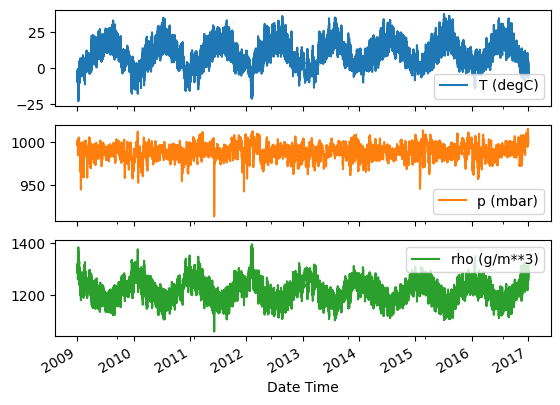

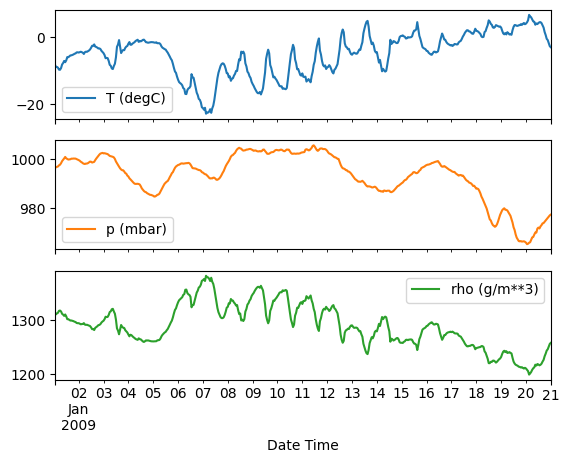

In [5]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [7]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

Text(0, 0.5, 'Wind Velocity [m/s]')

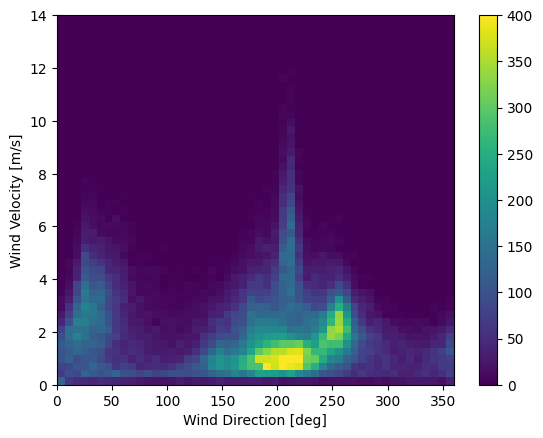

In [8]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')


In [9]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

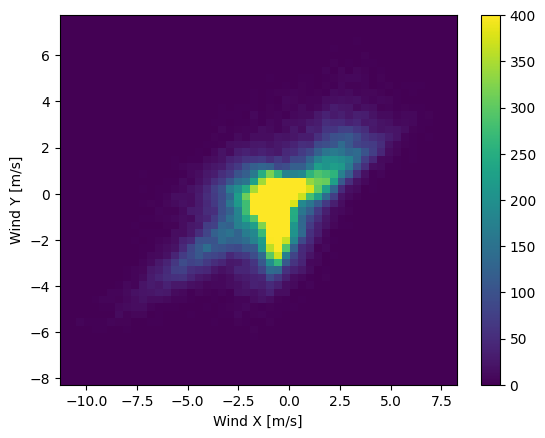

In [10]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')


In [11]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [12]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

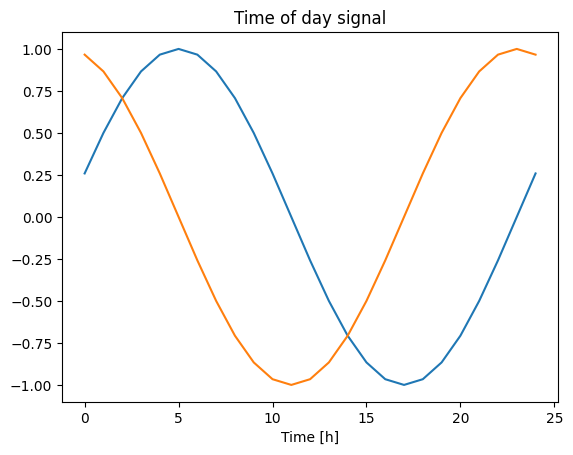

In [13]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [14]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):]

num_features = df.shape[1]

In [15]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std

In [16]:
train_df.to_csv(processed_pretraining_data_paths[dataset]["train"], index=False)
val_df.to_csv(processed_pretraining_data_paths[dataset]["eval"], index=False)

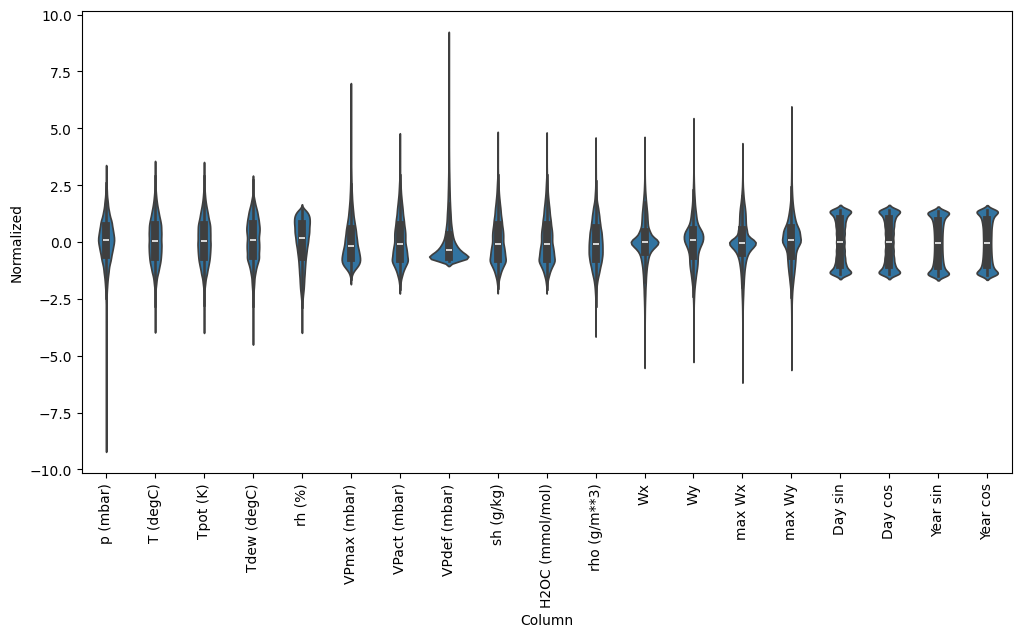

In [17]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [18]:
BATCH_SIZE = 64
window_length = 5
shift = 1
feature_columns = list(df.columns)

# metrics = feature_columns
metrics = ["T (degC)"]

train_dataset = TimeSeriesDataset(
    train_df,
    metrics=metrics,
    window_length=window_length,
    shift=shift,
    transform=transforms.Compose(
        [ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]
    ),
)
val_dataset = TimeSeriesDataset(
    val_df,
    metrics=metrics,
    window_length=window_length,
    shift=shift,
    transform=transforms.Compose(
        [ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]
    ),
)

In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
eval_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [20]:
for i, sample in enumerate(train_dataloader):
    if i == 0:
        print(i, sample["window"].shape, sample["target"].shape)
        break

0 torch.Size([64, 5, 19]) torch.Size([64, 1])


In [21]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [30]:
n_features = len(df.columns)
target_size = len(metrics)
d_model = 128
d_hid = 256
nlayers = 4
nhead = 4
dropout = 0.1
enc_dropout = 0

model = TimeSeriesTransformerModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    target_size=target_size,
    dropout=dropout,
    device=device,
)
model = model.to(device)


In [31]:
from torch.nn import MSELoss

model.eval()
mse_loss_weighted = MSELoss().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target)

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)
        print("Loss:", loss.item())

        if i == 0:
            break

torch.Size([64, 5, 19]) torch.Size([64, 5]) torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1])
Loss: 0.6433610916137695


In [37]:
learning_rate = 1e-4
num_epochs = 5

In [38]:
train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [39]:
num_training_steps = num_epochs * len(train_dataloader)

optimizer = AdamW(model.parameters(), lr=learning_rate)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

progress_bar = tqdm(range(num_training_steps))
early_stopper = EarlyStopper(patience=3)

for epoch in range(num_epochs):
    train_loss, train_r2_score = train_weightless(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate_weightless(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)

    if early_stopper.early_stop(eval_loss):
        print(f"Early stopping at epoch {epoch}")
        break

progress_bar.close()

100%|██████████| 4385/4385 [27:00<00:00,  2.71it/s]    


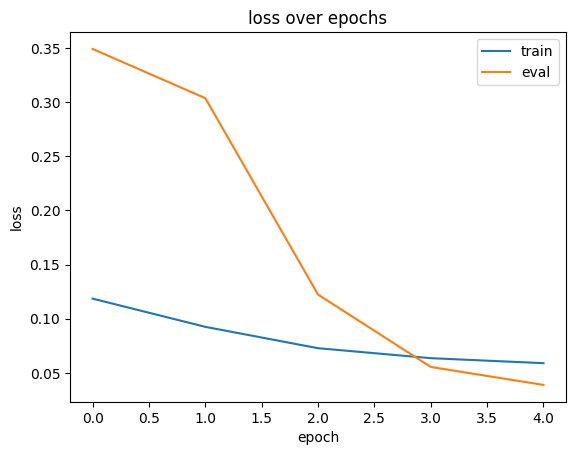

In [40]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

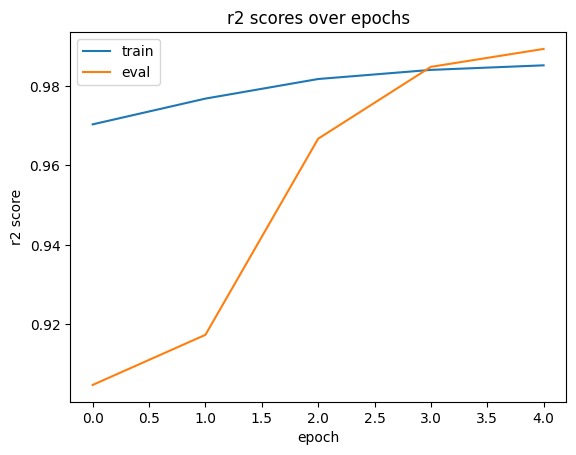

In [41]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()

In [49]:
print(model.transformer_encoder)

TransformerEncoder(
  (layers): ModuleList(
    (0-3): 4 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (linear1): Linear(in_features=128, out_features=256, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=256, out_features=128, bias=True)
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
)


In [51]:
state_dict = model.state_dict()
state_dict.keys()

odict_keys(['embedding.weight', 'embedding.bias', 'pos_encoder.pe', 'transformer_encoder.layers.0.self_attn.in_proj_weight', 'transformer_encoder.layers.0.self_attn.in_proj_bias', 'transformer_encoder.layers.0.self_attn.out_proj.weight', 'transformer_encoder.layers.0.self_attn.out_proj.bias', 'transformer_encoder.layers.0.linear1.weight', 'transformer_encoder.layers.0.linear1.bias', 'transformer_encoder.layers.0.linear2.weight', 'transformer_encoder.layers.0.linear2.bias', 'transformer_encoder.layers.0.norm1.weight', 'transformer_encoder.layers.0.norm1.bias', 'transformer_encoder.layers.0.norm2.weight', 'transformer_encoder.layers.0.norm2.bias', 'transformer_encoder.layers.1.self_attn.in_proj_weight', 'transformer_encoder.layers.1.self_attn.in_proj_bias', 'transformer_encoder.layers.1.self_attn.out_proj.weight', 'transformer_encoder.layers.1.self_attn.out_proj.bias', 'transformer_encoder.layers.1.linear1.weight', 'transformer_encoder.layers.1.linear1.bias', 'transformer_encoder.layers.

In [52]:
torch.save(state_dict, "../../weights/jena_climate.pt")

In [ ]:
to